In [2]:
import numpy as np
from scipy.linalg import eigh, eig
from scipy.stats import uniform, bernoulli
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

In [3]:
class ErdosRenyiFJ:
    def __init__(self, n, p, w_lower, w_upper, internal_lower, internal_upper, internal_dtbn="bernoulli", directed=False):
        '''
        n: number of nodes
        p: probably that each edge exists
        w_lower: min initial weight
        w_upper: max initial weight
        internal_lower: min internal opinion
        internal_upper: max internal opinion
        internal_dtbn: Distribution of internal opinions. Either "bernoulli" or "uniform".
        '''
        assert w_lower >= 0
        assert w_upper >= w_lower
        self.n = n
        self.directed = directed
        if directed:
            self.weights = bernoulli.rvs(p, size=[n,n]) * uniform.rvs(loc=w_lower, scale=w_upper - w_lower, size=[n, n])
            # zero out the diagonal since w_{ii} is only used for internal opinions rather than expressed opinions
            for i in range(n):
                self.weights[i][i] = 0
        else:
            upper_triangular_weights = np.triu(uniform.rvs(
                loc=w_lower, scale=w_upper - w_lower, size=[n, n])* bernoulli.rvs(p, size=[n,n]), k=1)
            self.weights = upper_triangular_weights + upper_triangular_weights.T - np.diag(upper_triangular_weights.diagonal())

        self.internal_dtbn = internal_dtbn
        if internal_dtbn == "bernoulli":
            self.internal = bernoulli.rvs(p=0.5, size=n)  # Bernoulli
        elif internal_dtbn == "uniform":
            self.internal = uniform.rvs(loc=internal_lower, scale=internal_upper - internal_lower, size=n)  # Uniform random
        else:
            raise Exception("Unknown internal opinion distribution: " + internal_dtbn)
        
        self.expressed = self.internal.copy()

    def __repr__(self):
        return f'weights: \n{self.weights}\ninternal: {self.internal}\nexpressed: {self.expressed}'

    def laplacian(self):
        degree_matrix = np.diag(np.sum(self.weights, axis=1))
        laplacian = degree_matrix - self.weights
        return laplacian

    def disagreement(self):
        disagreement = 0
        for i, j in itertools.product(range(self.n), range(self.n)):
            disagreement += abs(self.weights[i][j]) * (self.expressed[i] - self.expressed[j]) ** 2
        return disagreement

    def polarization(self):
        avg_expressed = np.sum(self.expressed) / self.n
        mean_centered_expressed = self.expressed - avg_expressed
        return np.dot(mean_centered_expressed, mean_centered_expressed)

    def update_weights(self):
        pass

    def run_one_step(self):
        new_expressed = self.expressed.copy()
        self.expressed = (self.internal + self.weights @ self.expressed) / (1 + np.sum(self.weights, axis=1))
        self.update_weights()
        
    def run_t_steps(self, t):
        ''' Run t steps of FJ '''
        for i in range(t):
            self.run_one_step()

    def to_nx_graph(self, threshold):
        '''
        Convert graph to networkx graph (with weighted edges), where edge between i and j exists if weights[i][j] >= threshold.
        The networkx graph is directed if and only if this graph is directed.
        '''
        nodes = list(range(self.n))
        edges = []
        
        for i in range(self.n):
            for j in range(self.n):
                if self.weights[i][j] >= threshold:
                    edges.append((i, j, self.weights[i][j]))
        
        # Create a weighted graph
        if self.directed:
            G = nx.DiGraph()
        else:
            G = nx.Graph()
        G.add_nodes_from(nodes)
        G.add_weighted_edges_from(edges)
        return G

    def plot_network(self, threshold=0.001, title="Erdos Renyi Graph"):
        '''
        Plot the network, where edge between i and j exists if weights[i][j] >= threshold.
        '''
        G = self.to_nx_graph(threshold)
        
        # Get positions for nodes
        pos = nx.spring_layout(G)  # Spring layout for a visually appealing result
        
        # Draw the graph
        plt.figure(figsize=(8, 6))

        node_cmap=plt.cm.winter
        edges, edge_weights = zip(*nx.get_edge_attributes(G, 'weight').items())
        nx.draw(G,
                pos,
                node_color=[node_cmap(self.expressed[i]) for i in range(self.n)],
                edgelist=edges,
                edge_color=edge_weights,
                width=2.0,
                node_size=10,
                edge_cmap=plt.cm.Blues)
        
        plt.title(title)
        plt.show()

    def get_components(self, threshold=0.001):
        '''
        Returns the connected components (if undirected)
        or weakly connected components (if directed) of this graph,
        sorted in decreasing order by size.
        '''
        G = self.to_nx_graph(threshold)
        if self.directed:
            return sorted(nx.weakly_connected_components(G), key=len, reverse=True)
        else:
            return sorted(nx.connected_components(G), key=len, reverse=True)

    def largest_component_size(self, threshold=0.001):
        '''
        Returns the size of the largest connected component (if undirected)
        or the size of the largest weakly connected component (if directed).
        '''
        conn_comps = self.get_components(threshold)
        return len(conn_comps[0])

    def num_components(self, threshold=0.001):
        '''
        Returns the number of connected components (if undirected)
        or the number of weakly connected components (if directed).
        '''
        conn_comps = self.get_components(threshold)
        return len(conn_comps)

In [4]:
class HalvingFJ(ErdosRenyiFJ):
    def __init__(self, n, p, w_lower, w_upper, internal_lower, internal_upper, theta, internal_dtbn="bernoulli", discount_factor=1/2, directed=False):
        ''' people whose expressed opinion differ by more than theta have their weights multiplied by the discount factor '''
        super().__init__(n, p, w_lower, w_upper, internal_lower, internal_upper, internal_dtbn, directed)
        self.theta = theta
        self.discount_factor = discount_factor
    
    def update_weights(self):
        # np.abs(self.expressed.reshape(-1, 1) - self.expressed) > self.theta is 1 if they're very different and 0 if they're close
        self.weights = (1 - (np.abs(self.expressed.reshape(-1, 1) - self.expressed) > self.theta) * (1 - self.discount_factor)) * self.weights

    def plot_network(self, threshold=0.001, title="Halving FJ"):
        super().plot_network(threshold, title)

disagreement: 16.806014991888762
polarization: 1.5369677008629936
size of largest component: 300


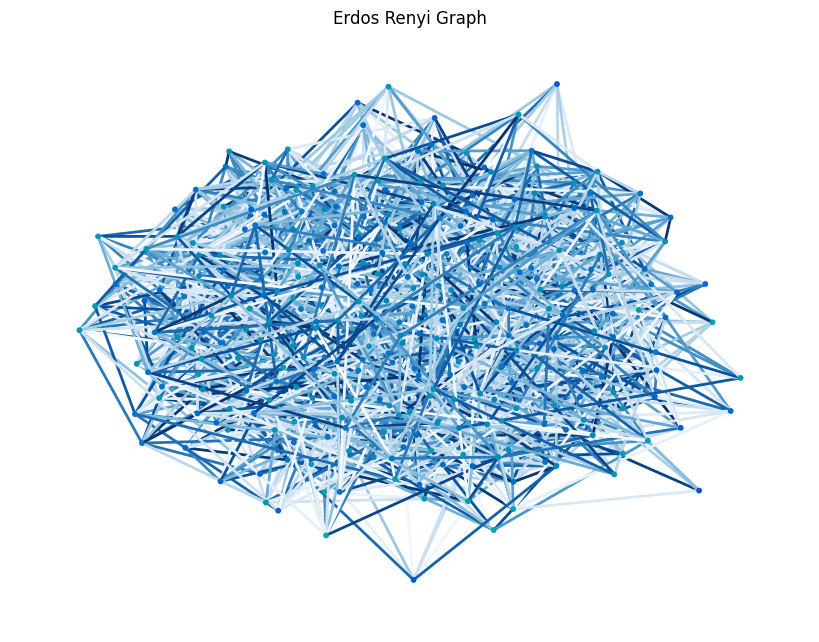

In [5]:
G = ErdosRenyiFJ(n=300, p=0.05, w_lower=0, w_upper=1, internal_lower=0, internal_upper=1)
G.run_t_steps(1000)
# print(G)
print("disagreement:", G.disagreement())
print("polarization:", G.polarization())
print("size of largest component:", G.largest_component_size())
G.plot_network()

In [6]:
G = HalvingFJ(n=10, p=0.05, w_lower=0, w_upper=1, internal_lower=0, internal_upper=1, theta=0.2)
G.run_t_steps(1000)
# print(G)
print("disagreement:", G.disagreement())
print("polarization:", G.polarization())
print("size of largest component:", G.largest_component_size())
print(G)

disagreement: 8.063324009296285e-303
polarization: 2.0999999999999996
size of largest component: 2
weights: 
[[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  4.03166200e-303 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 6.66638174e-001 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.0000

In [7]:
def get_disagreement_polarization_eigenvalues(model, num_steps=1000, num_trials=100):
    disagreements = []
    polarizations = []
    eigenvalues = []
    for trial in range(num_trials):
        G = model()
        G.run_t_steps(num_steps)
        disagreements.append(G.disagreement())
        polarizations.append(G.polarization())
        eigenvalues.append(eigh(G.laplacian(), eigvals_only=True))
    return np.sum(disagreements) / num_trials, np.sum(polarizations) / num_trials, np.sum(eigenvalues, axis=0) / num_trials

### Basic FJ model on $G_{n,p}$ for $p=\frac12$ where all weights are $w_{ij}$ uniform $[0,1]$ i.i.d., internal opinions are uniform $[0,1]$ i.i.d.

In [8]:
model = lambda: ErdosRenyiFJ(n=300, p=1/2, w_lower=0, w_upper=1, internal_lower=0, internal_upper=1)
get_disagreement_polarization_eigenvalues(model, num_steps=1000, num_trials=10)

(np.float64(1.9669128064654824),
 np.float64(0.0134146724024581),
 array([5.68434189e-15, 5.73587957e+01, 5.87205153e+01, 5.93226872e+01,
        5.97978510e+01, 6.00922478e+01, 6.03649715e+01, 6.06602966e+01,
        6.09505936e+01, 6.11794513e+01, 6.13805100e+01, 6.16049149e+01,
        6.18590279e+01, 6.20085674e+01, 6.21788435e+01, 6.23412758e+01,
        6.25137888e+01, 6.27020937e+01, 6.28205160e+01, 6.29447439e+01,
        6.31069368e+01, 6.32467698e+01, 6.33472648e+01, 6.34742970e+01,
        6.35786120e+01, 6.37310234e+01, 6.38557869e+01, 6.39975719e+01,
        6.41162237e+01, 6.42025945e+01, 6.43534488e+01, 6.44594986e+01,
        6.45876156e+01, 6.46913188e+01, 6.47802523e+01, 6.49079576e+01,
        6.50009231e+01, 6.51322456e+01, 6.52286954e+01, 6.53218488e+01,
        6.54408021e+01, 6.55328546e+01, 6.56172781e+01, 6.57327139e+01,
        6.58406508e+01, 6.59349102e+01, 6.60392688e+01, 6.61322408e+01,
        6.62448468e+01, 6.63384813e+01, 6.64723697e+01, 6.65698757e+01

### Basic FJ model on $G_{n,p}$ for $p=\frac{1}{n}$ where all weights are $w_{ij}$ uniform $[0,1]$ i.i.d., internal opinions are uniform $[0,1]$ i.i.d.

In [9]:
model = lambda: ErdosRenyiFJ(n=300, p=1/300, w_lower=0, w_upper=1, internal_lower=0, internal_upper=1)
get_disagreement_polarization_eigenvalues(model, num_steps=1000, num_trials=10)

(np.float64(13.762448166872707),
 np.float64(52.812412690786836),
 array([-1.21188595e-15, -1.00894784e-15, -8.54131531e-16, -8.07521874e-16,
        -7.35005074e-16, -6.53456338e-16, -6.08623266e-16, -5.81588853e-16,
        -5.40201747e-16, -5.22219267e-16, -4.93841961e-16, -4.74823952e-16,
        -4.56704251e-16, -4.32182489e-16, -4.05454079e-16, -3.84250712e-16,
        -3.64334431e-16, -3.46822008e-16, -3.30321512e-16, -3.13561315e-16,
        -3.03453715e-16, -2.90613810e-16, -2.75012213e-16, -2.57847679e-16,
        -2.45505898e-16, -2.37274313e-16, -2.24517923e-16, -2.15029173e-16,
        -2.00964332e-16, -1.87938811e-16, -1.79332283e-16, -1.71832385e-16,
        -1.60584386e-16, -1.50604308e-16, -1.41684156e-16, -1.35908374e-16,
        -1.28595380e-16, -1.20754139e-16, -1.14036307e-16, -1.04024580e-16,
        -9.56987019e-17, -8.87642846e-17, -8.29362626e-17, -7.79329509e-17,
        -7.14409314e-17, -6.51552687e-17, -6.02163178e-17, -5.35931076e-17,
        -4.96261285e-1

## Weight Halving Threshold Model with uniform threshold $\theta_{ij} = \theta$

In [10]:
average_disagreements = []
average_polarizations = []
average_eigenvalues = []
thetas = np.linspace(0,1,num=20)
for theta in thetas:
    model = lambda: HalvingFJ(n=300, p=1/20, w_lower=0, w_upper=1, internal_lower=0, internal_upper=1, theta=theta)
    average_disagreement, average_polarization, average_eigenvalue = get_disagreement_polarization_eigenvalues(model, num_steps=1000, num_trials=10)
    average_disagreements.append(average_disagreement)
    average_polarizations.append(average_polarization)
    average_eigenvalues.append(average_eigenvalue)

print(average_disagreements)
print(average_polarizations)

[np.float64(1.0297527527267108e-298), np.float64(3.7575966261862545e-30), np.float64(9.235040277120894e-30), np.float64(0.019520399851010773), np.float64(4.5415788410879925), np.float64(19.487737355399663), np.float64(17.84257920241867), np.float64(17.341168806538644), np.float64(17.258390610360387), np.float64(17.357349785913485), np.float64(16.995480464369702), np.float64(17.07001052295488), np.float64(17.105387692700084), np.float64(17.238446266161926), np.float64(16.94688366995663), np.float64(17.15170381090366), np.float64(17.13922152320429), np.float64(17.368353759304085), np.float64(17.153699747377804), np.float64(17.104793784374074)]
[np.float64(74.83733333333333), np.float64(74.62366666666667), np.float64(74.46133333333333), np.float64(74.47681536820843), np.float64(58.21379761024749), np.float64(2.8657407125379515), np.float64(1.8796707112959887), np.float64(1.7361434631199544), np.float64(1.670628506638041), np.float64(1.6796459148211198), np.float64(1.5943566092323183), np.

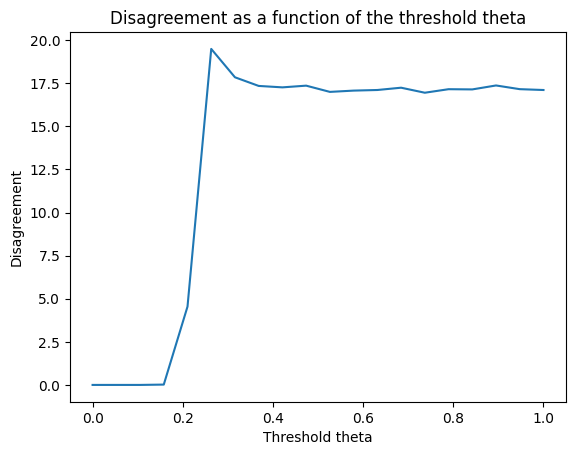

In [11]:
fig, ax = plt.subplots()
ax.set_xlabel('Threshold theta')
ax.set_ylabel('Disagreement')
ax.set_title('Disagreement as a function of the threshold theta')
ax.plot(thetas, average_disagreements)
fig.savefig('threshold_model_halve_weight_disagreement.png')

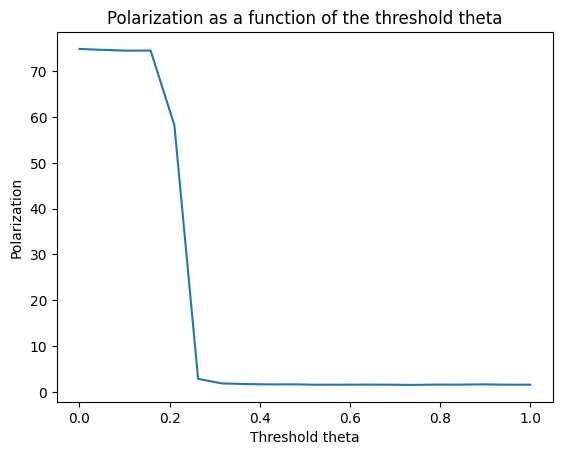

In [12]:
fig, ax = plt.subplots()
ax.set_xlabel('Threshold theta')
ax.set_ylabel('Polarization')
ax.set_title('Polarization as a function of the threshold theta')
ax.plot(thetas, average_polarizations)
fig.savefig('threshold_model_halve_weight_polarization.png')

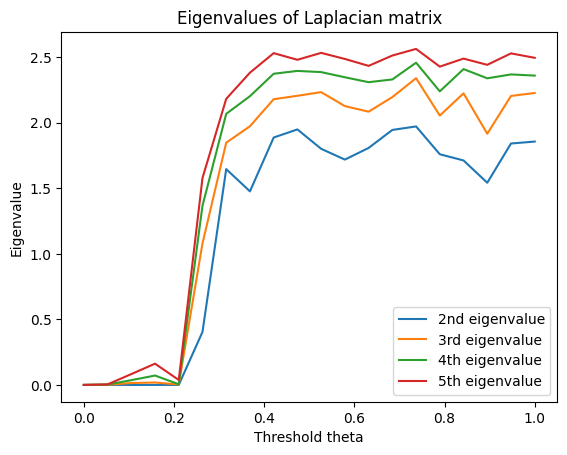

In [13]:
fig, ax = plt.subplots()
ax.set_xlabel('Threshold theta')
ax.set_ylabel('Eigenvalue')
ax.set_title('Eigenvalues of Laplacian matrix')
ax.plot(thetas, np.array(average_eigenvalues)[:,1], label='2nd eigenvalue')
ax.plot(thetas, np.array(average_eigenvalues)[:,2], label='3rd eigenvalue')
ax.plot(thetas, np.array(average_eigenvalues)[:,3], label='4th eigenvalue')
ax.plot(thetas, np.array(average_eigenvalues)[:,4], label='5th eigenvalue')
ax.legend()
fig.savefig('threshold_model_halve_weight_polarization.png')

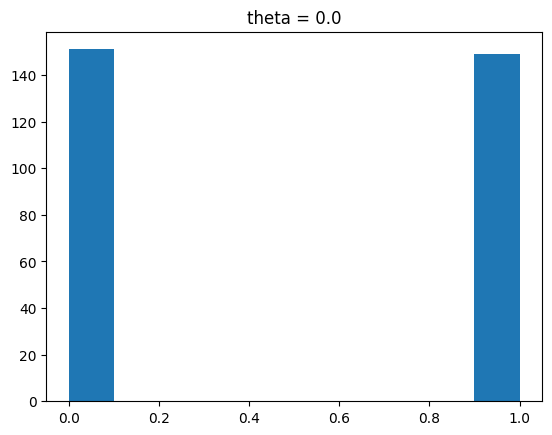

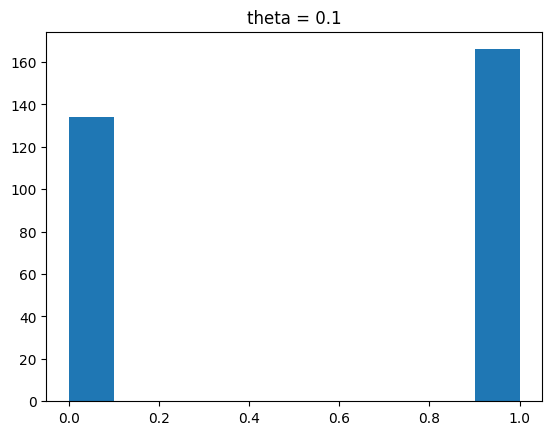

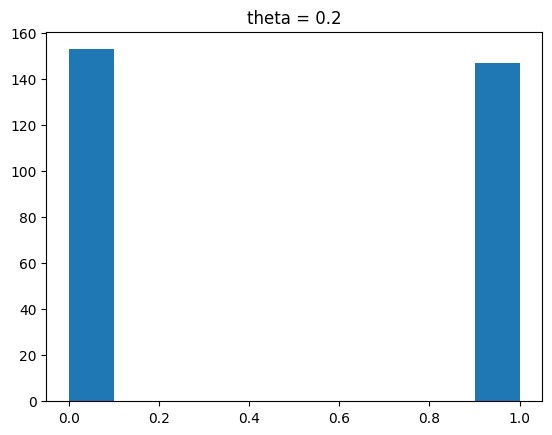

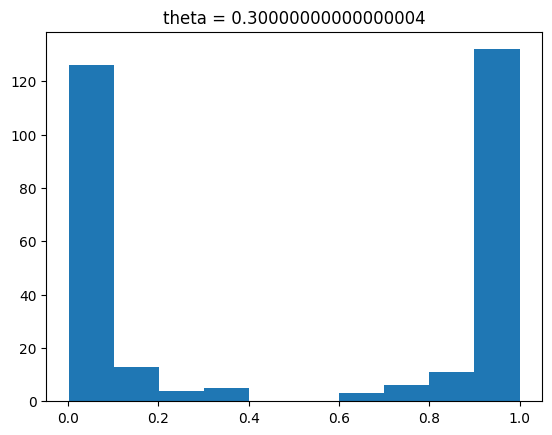

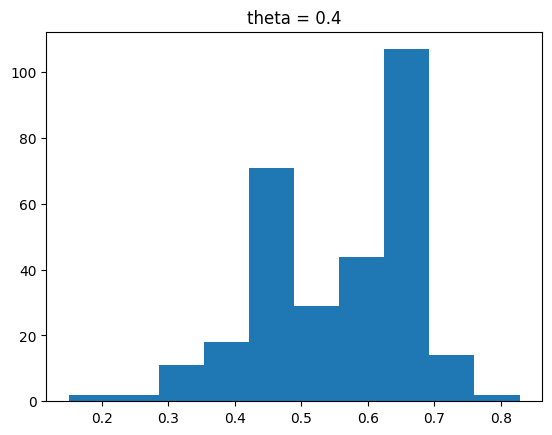

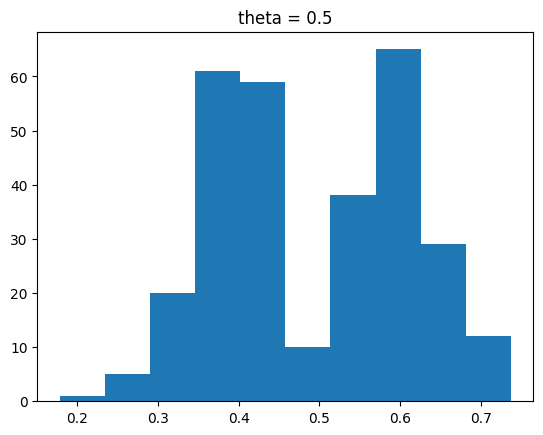

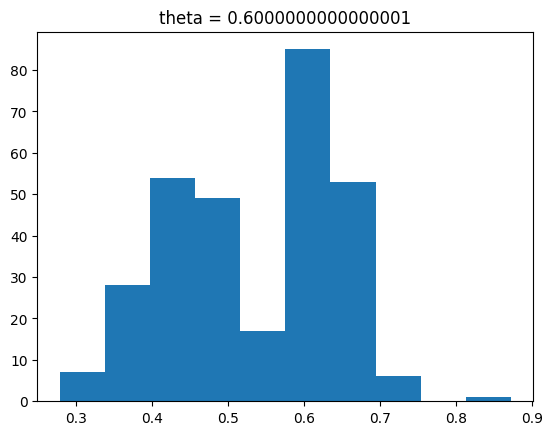

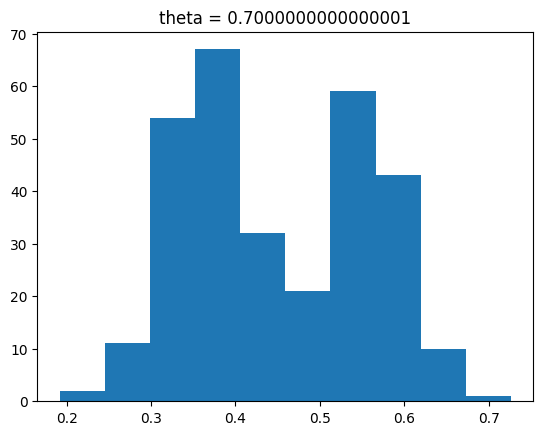

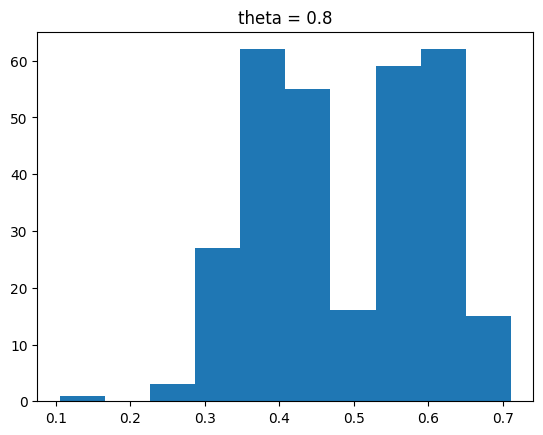

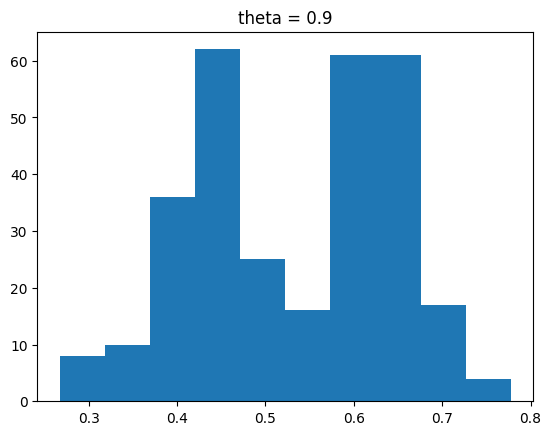

In [14]:
for theta in np.arange(0, 1, 0.1):
    G = HalvingFJ(n=300, p=1/30, w_lower=0, w_upper=1, internal_lower=0, internal_upper=1, theta=theta)
    G.run_t_steps(1000)
    plt.hist(G.expressed)
    plt.title(f'theta = {theta}')
    plt.show()

1.0493806326740821e-27
74.98666666666662


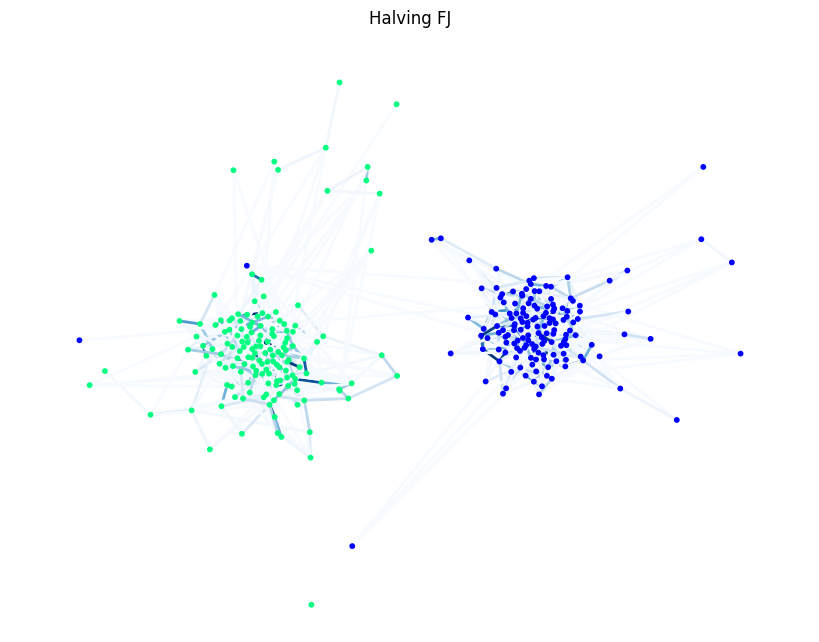

In [28]:
G = HalvingFJ(n=300, p=0.05, w_lower=0, w_upper=1, internal_lower=0, internal_upper=1, theta=0.05)
G.run_t_steps(100)
# print(G)
print(G.disagreement())
print(G.polarization())
G.plot_network()

In [29]:
def component_info(n, p_range, theta_range, num_steps, num_trials):
    '''
    num_steps: number of steps to run for each trial
    num_trials: number of trials for each p and theta
    '''
    # avg_largest_comp_sizes = np.zeros((len(p_range), len(theta_range)))
    avg_largest_comp_sizes = {}
    avg_num_comps = {}
    for p in p_range:
        for theta in theta_range:
            sizes = []
            num_comps = []
            for i in range(num_trials):
                G = HalvingFJ(n, p, w_lower=0, w_upper=1, internal_lower=0, internal_upper=1, internal_dtbn="bernoulli", theta=theta)
                G.run_t_steps(num_steps)
                sizes.append(G.largest_component_size())
                num_comps.append(G.num_components())
            avg_largest_comp_sizes[(p, theta)] = sum(sizes) / num_trials
            avg_num_comps[(p, theta)] = sum(num_comps) / num_trials
    return avg_largest_comp_sizes, avg_num_comps

In [30]:
n = 300
p_range = np.linspace(start=0.01, stop=0.20, num=20)
theta_range = np.linspace(start=0.05, stop=0.50, num=100)
num_steps = 50
num_trials = 5
avg_largest_comp_sizes, avg_num_comps = component_info(n, p_range, theta_range, num_steps, num_trials)

KeyboardInterrupt: 

In [ ]:
for (p, theta) in avg_largest_comp_sizes:
    avg = avg_largest_comp_sizes[(p, theta)]
    print(f"p = {p:.3f}, theta = {theta:.3f}, size = {avg}")

In [ ]:
sizes_arr = np.zeros((len(p_range), len(theta_range)))
for i, p in enumerate(p_range):
    for j, theta in enumerate(theta_range):
        sizes_arr[i][j] = avg_largest_comp_sizes[(p, theta)]
ax = sns.heatmap(sizes_arr, yticklabels=np.round(p_range, 2))
ax.set_xticks(np.linspace(start=0, stop=100, num=11))
ax.set_xticklabels(np.round(np.linspace(start=0.05, stop=0.50, num=11), 2))
ax.invert_yaxis()
ax.set_xlabel("theta")
ax.set_ylabel("p")
plt.show()

# Preprocessing Datasets

## Who-trust-whom Bitcoin platform: directed, weight represents trust, normalized to [-1, 1]

In [15]:
import csv
import networkx as nx

G = nx.DiGraph()

with open('dataset/soc-sign-bitcoinotc.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        source = int(row[0])
        target = int(row[1])
        rating = float(row[2])

        # Normalize the rating to (0, 1]
        normalized_rating = rating / 10.0

        G.add_node(source)
        G.add_node(target)
        G.add_edge(source, target, weight=normalized_rating)

In [16]:
print(G.number_of_nodes())
print(G.number_of_edges())

5881
35592


## Opinion review website with who-trust-whom, weights are either -1 or 1

In [17]:
import networkx as nx

G = nx.DiGraph()

with open('dataset/soc-sign-epinions.txt', 'r') as file:
    for line in file:
        if line.startswith('#'):
            continue
        parts = line.strip().split()
        if len(parts) != 3:
            continue
        source, target, sign = parts
        source = int(source)
        target = int(target)
        weight = int(sign)  # Should be either 1 or -1

        G.add_node(source)
        G.add_node(target)
        G.add_edge(source, target, weight=weight)

In [18]:
print(G.number_of_nodes())
print(G.number_of_edges())

131825
841345


### EU research institution email communication, weights either 0 or 1. People who wrote at least one email have an edge with weight 1 in between. Also people from same department are assumed to know each other (has an edge in between).

In [19]:
import networkx as nx
from itertools import combinations

# Initialize an undirected graph
G = nx.Graph()

group_file = 'dataset/email-EU/email-EU-core-department-labels.txt'
group_dict = {}

with open(group_file, 'r') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) != 2:
            continue
        node_id, group_id = parts
        node_id = int(node_id)
        group_id = int(group_id)
        G.add_node(node_id)
        if group_id not in group_dict:
            group_dict[group_id] = []
        group_dict[group_id].append(node_id)

# Add edges between all nodes in the same group
for group_nodes in group_dict.values():
    for u, v in combinations(group_nodes, 2):
        if not G.has_edge(u, v):
            G.add_edge(u, v, weight=1)

edge_file = 'dataset/email-EU/email-EU-core.txt'
with open(edge_file, 'r') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) != 2:
            continue
        u, v = parts
        u = int(u)
        v = int(v)
        G.add_node(u)
        G.add_node(v)
        if not G.has_edge(u, v):
            G.add_edge(u, v, weight=1)

for u, v, data in G.edges(data=True):
    assert data['weight'] == 1, f"Edge ({u}, {v}) has incorrect weight {data['weight']}"

In [20]:
print(G.number_of_nodes())
print(G.number_of_edges())

1005
34857


## Visualize the graph G (without opinion assigned yet)

/var/folders/7k/wztcwbp158q2tcpzv3xzf5zr0000gn/T/ipykernel_29776/1031906804.py:20: UserWarning: 

The arrowsize keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_width, alpha=0.5, arrowsize=5)


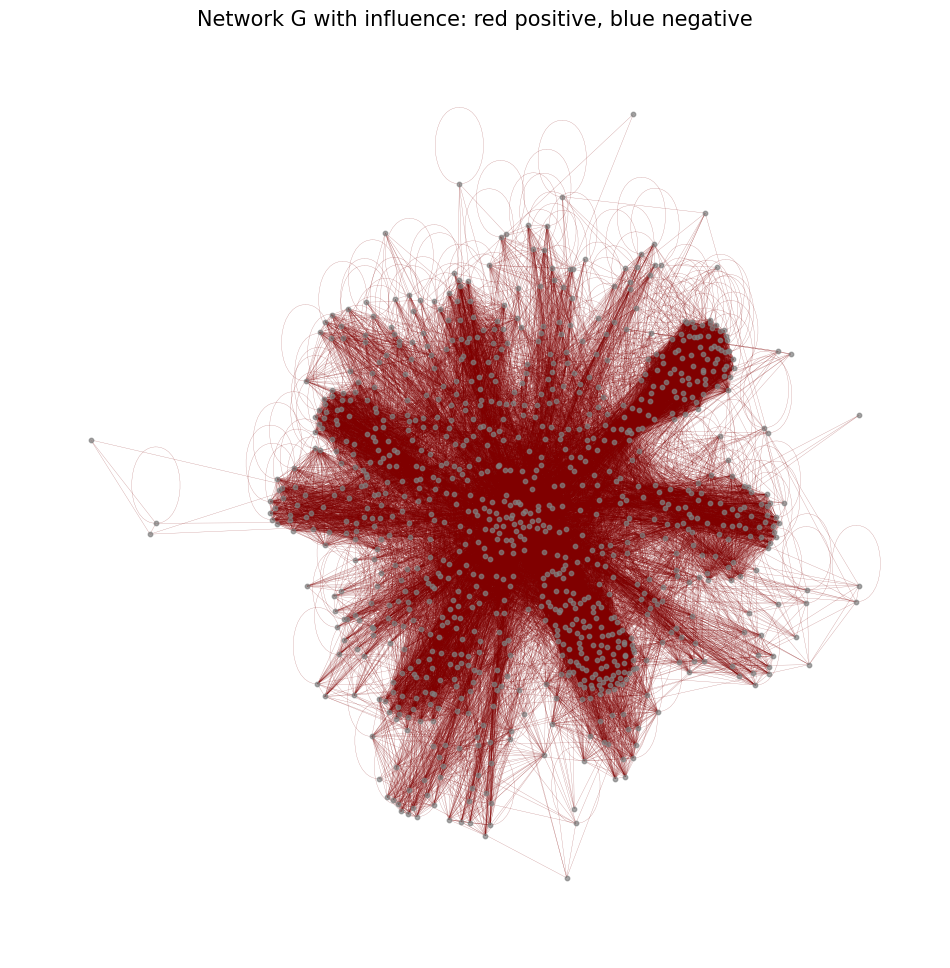

In [21]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

pos = nx.spring_layout(G, k=0.15, iterations=20, seed=42)

edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]

# Create a color map
cmap = plt.cm.seismic  # Blue for negative, white for neutral, red for positive
norm = mcolors.Normalize(vmin=-1, vmax=1)
edge_colors = [cmap(norm(w)) for w in weights]

node_size = 10
edge_width = 0.2

plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='grey', alpha=0.7)
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_width, alpha=0.5, arrowsize=5)

plt.axis('off')
plt.title('Network G with influence: red positive, blue negative', fontsize=15)
plt.show()

## Now choose a graph G generated from one of the dataset. Compute the converged expressed opinion with threshold model.

In [22]:
import numpy as np
import networkx as nx
from scipy.stats import uniform
from scipy.special import expit

class SelfDefinedGraphFJ:
    def __init__(self, graph, internal_lower, internal_upper, model_type="normal", theta=None):
        self.graph = graph
        self.node_list = list(graph.nodes())
        self.node_to_index = {node: idx for idx, node in enumerate(self.node_list)}
        self.index_to_node = {idx: node for idx, node in enumerate(self.node_list)}
        self.n = len(self.node_list)
        
        # Initialize weights matrix (allowing negative weights)
        self.weights = np.zeros((self.n, self.n))
        for u, v, data in graph.edges(data=True):
            i = self.node_to_index[u]
            j = self.node_to_index[v]
            self.weights[i, j] = data['weight']
        np.fill_diagonal(self.weights, 0)
        
        self.internal = uniform.rvs(loc=internal_lower, scale=internal_upper - internal_lower, size=self.n)
        self.expressed = self.internal.copy()
        
        self.model_type = model_type
        self.theta = theta if theta is not None else 0.5  # Default theta
    
    def __repr__(self):
        return f'weights: \n{self.weights}\ninternal: {self.internal}\nexpressed: {self.expressed}'
    
    def disagreement(self):
        disagreement = 0
        for u, v, data in self.graph.edges(data=True):
            i = self.node_to_index[u]
            j = self.node_to_index[v]
            weight = abs(self.weights[i, j])
            disagreement += weight * (self.expressed[i] - self.expressed[j]) ** 2
        return disagreement
    
    def polarization(self):
        avg_expressed = np.mean(self.expressed)
        mean_centered_expressed = self.expressed - avg_expressed
        return np.dot(mean_centered_expressed, mean_centered_expressed)
    
    def update_weights(self):
        if self.model_type == "normal":
            pass
        elif self.model_type == "threshold":
            for u, v in self.graph.edges():
                i = self.node_to_index[u]
                j = self.node_to_index[v]
                if abs(self.expressed[i] - self.expressed[j]) >= self.theta:
                    self.weights[i, j] /= 2
        else:
            raise ValueError(f"Unknown model_type '{self.model_type}'. Supported types: 'normal', 'threshold'.")
    
    def run_one_step(self):
        total_influence = self.internal + self.weights @ self.expressed
        self.expressed = expit(total_influence)
        self.update_weights()
    
    def run_t_steps(self, t):
        for _ in range(t):
            self.run_one_step()

In [23]:
def get_disagreement_polarization(model, num_steps=1000, num_trials=100):
    disagreements = []
    polarizations = []
    for _ in range(num_trials):
        G_model = model()
        G_model.run_t_steps(num_steps)
        disagreements.append(G_model.disagreement())
        polarizations.append(G_model.polarization())
    return np.mean(disagreements), np.mean(polarizations)

In [24]:
# Instantiate the model
model = lambda: SelfDefinedGraphFJ(graph=G, internal_lower=0, internal_upper=1, model_type="threshold", theta = 0.03)
avg_disagreement, avg_polarization = get_disagreement_polarization(model, num_steps=1000, num_trials=2)
print(f"Average Disagreement: {avg_disagreement}")
print(f"Average Polarization: {avg_polarization}")

Average Disagreement: 0.04747006575938202
Average Polarization: 5.48310890405096


In [25]:
expressed_opinions = model().expressed

### Visualization of the final graph with expressed opinion

In [26]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as mcolors
import numpy as np

def plot_graph_with_opinions(model):
    # Choose a colormap suitable for values in [0, 1]
    model = model()
    expressed_opinions = model.expressed
    G = model.graph
    cmap = plt.cm.viridis
    norm = mcolors.Normalize(vmin=0, vmax=1)
    
    node_colors = [expressed_opinions[model.node_to_index[node]] for node in G.nodes()]
    node_colors_mapped = [cmap(norm(opinion)) for opinion in node_colors]
    
    pos = nx.spring_layout(G, k=0.15, iterations=20, seed=42)
    node_size = 50
    edge_width = 0.1
    
    # Plot the graph
    plt.figure(figsize=(12, 12))
    nx.draw_networkx_nodes(
        G,
        pos,
        node_size=node_size,
        node_color=node_colors,
        cmap=cmap,
        vmin=0,
        vmax=1,
        alpha=0.8
    )
    nx.draw_networkx_edges(
        G,
        pos,
        width=edge_width,
        edge_color='grey',
        alpha=0.3,
        arrowsize=5
    )
    
    plt.axis('off')
    plt.title('Graph of Expressed Opinions', fontsize=15)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Expressed Opinion', rotation=270, labelpad=15)  
    plt.show()

/var/folders/7k/wztcwbp158q2tcpzv3xzf5zr0000gn/T/ipykernel_29776/2962674904.py:33: UserWarning: 

The arrowsize keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

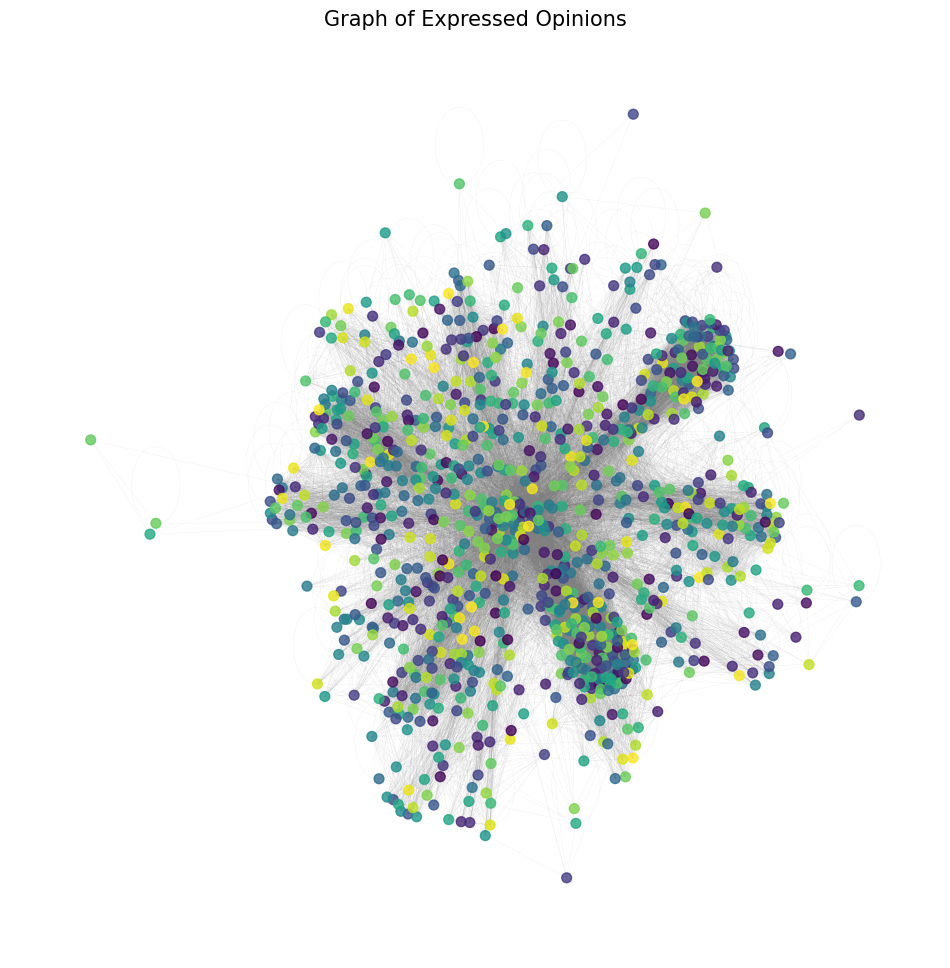

In [27]:
plot_graph_with_opinions(model)